In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
import pickle
import glob
import itertools
from typing import List, Callable

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.settings.tier import Tier
from src.settings.strategy import Strategy

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists, load_model

In [3]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

In [4]:
def get_lime_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("lime", tier, strategy)
    df = pd.concat([pd.read_json(path) for path in paths])
    return df

def get_shap_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("shap", tier, strategy)

    pickled_explanations = {}

    for path in paths:
        with open(path, mode='rb') as shap_explanation:
            clean_path = path.replace(f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/shap/{strategy}_", "").replace(".pickle", "")
            pickled_explanations[clean_path] = pickle.load(shap_explanation)

    return pickled_explanations




def get_explanation_paths(type: str, tier: Tier, strategy: Strategy):
    explanation_path = f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/{type}"
    paths = glob.glob(f"{explanation_path}/{strategy}_*")
    return paths

def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)
        return fig

def save_fig(path: str, name: str):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight')
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight')
    
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
shap_explanations = get_shap_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)

/home/tvangraft/tudelft/thesis/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def count_overlap(enzymes_one: List, enzymes_two: List):
    idx = 20
    return len(set(enzymes_one[:idx]) & set(enzymes_two[:idx])) / len(enzymes_one[:idx])

def kendalltau(enzymes_one: List, enzymes_two: List):
    from scipy.stats import kendalltau
    return kendalltau(enzymes_one, enzymes_two)[0]

def rank_correlation_metabolite_id(df: pd.DataFrame, metabolite_id: str, agg_func):
    _df = df[df['metabolite_id'] == metabolite_id].set_index('KO_ORF')
    return rank_correlation(_df, agg_func)

def rank_correlation_knockout(df: pd.DataFrame, knockout_id: str, agg_func):
    _df = df[df['KO_ORF'] == knockout_id].set_index('metabolite_id')
    return rank_correlation(_df, agg_func)

def rank_correlation_all(df: pd.DataFrame, agg_func: Callable):
    _df = df.reset_index()
    return rank_correlation(_df, agg_func)

def rank_correlation(_df: pd.DataFrame, agg_func: Callable):
    unique_knockouts = _df.index.to_list()
    knockout_combinations = list(itertools.combinations(unique_knockouts, r=2))
    
    n = len(unique_knockouts)
    r = np.ones((n, n))
    triu = np.triu_indices(n, 1)
    tril = np.tril_indices(n, -1)
    
    key = 'exp_enzymes'
    kendalltau_correllation = [agg_func(_df.loc[left_knockout][key], _df.loc[right_knockout][key]) for (left_knockout, right_knockout) in knockout_combinations]
    
    r[triu] = kendalltau_correllation
    r[tril] = r.T[tril]
    
    return r, unique_knockouts



In [6]:
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ONE_VS_ALL)
df

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred
0,YPL026C,pyr,"[YER012W, YLR438W, YOR280C, YGR254W, YGR175C, ...","[-0.0350430173, 0.026642728900000003, -0.02600...",0.546306,0.703221
1,YJR066W,pyr,"[YER012W, YLR438W, YGR254W, YGL255W, YDR019C, ...","[-0.0347622895, 0.0292593771, 0.0256017531, 0....",0.420767,0.786203
2,YGL083W,pyr,"[YER012W, YOR280C, YGR254W, YDR019C, YPL262W, ...","[-0.0335921847, -0.0257139693, 0.0248903138, 0...",0.513452,0.780766
3,YOL128C,pyr,"[YLR438W, YOR280C, YDR019C, YGR254W, YGL255W, ...","[0.0289031254, -0.027392576800000002, 0.023113...",0.562521,0.743092
4,YHR030C,pyr,"[YLR438W, YOR280C, YGR254W, YGL255W, YDR019C, ...","[0.0295318674, -0.027098685900000002, 0.023732...",0.408405,0.779679
...,...,...,...,...,...,...
90,YPL026C,r5p,"[YER012W, YLR438W, YOR280C, YGR254W, YGL255W, ...","[-0.0348959597, 0.0285055798, -0.0269254438, 0...",0.546306,0.709095
91,YHR079C,r5p,"[YER012W, YLR438W, YOR280C, YGR254W, YGL255W, ...","[-0.0335005575, 0.029474713000000003, -0.02584...",-0.248365,-0.776184
92,YKL166C,r5p,"[YLR438W, YOR280C, YDR019C, YGL255W, YPL262W, ...","[0.0282061355, -0.0268510278, 0.0220204559, 0....",0.463182,0.522279
93,YNL298W,r5p,"[YLR438W, YOR280C, YGR254W, YGL255W, YGR175C, ...","[0.0292871288, -0.024271075200000002, 0.023605...",-0.168072,-0.417934


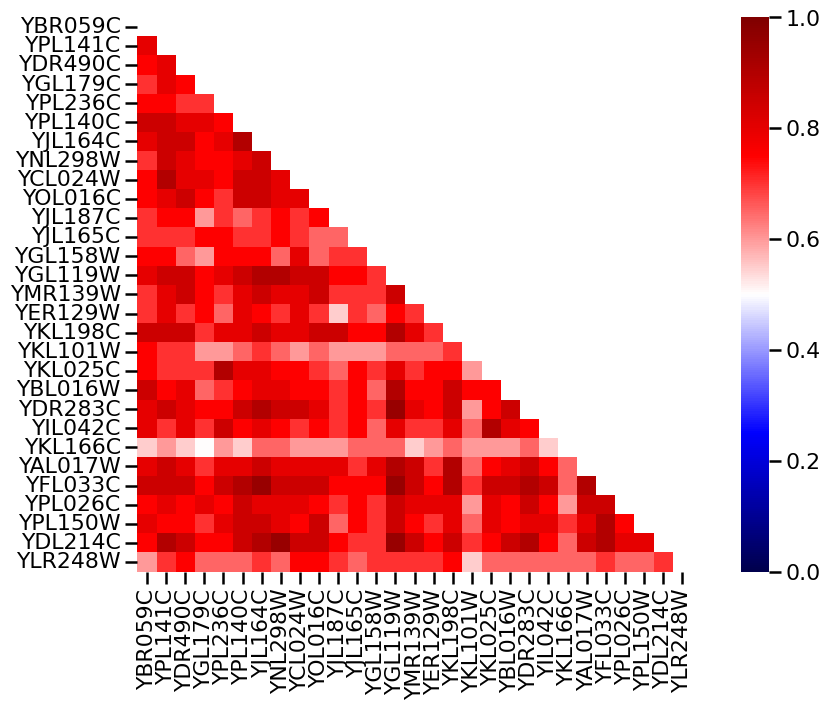

In [7]:
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
figure = set_context(MODE)
ax = figure.add_subplot(1, 1, 1)
unique_metabolite_id = 'pyr'
correlation_matrix, knockouts = rank_correlation_metabolite_id(df, unique_metabolite_id, count_overlap)
sns.heatmap(
    correlation_matrix, 
    square=True, 
    # annot=True,
    # fmt=".2f",
    vmax=1,
    vmin=0,
    ax=ax,
    xticklabels=knockouts,
    yticklabels=knockouts,
    cmap="seismic",
    mask=np.triu(correlation_matrix),
    # cbar=False,
)
plt.savefig(f"./{unique_metabolite_id}.png")
save_fig(path=f'./images/{MODE}/explanation/', name="pyruvate_count_overlap")

# Shap analysis

In [8]:
from shap import KernelExplainer, kmeans, Explanation
from shap.plots import beeswarm

In [36]:
x = np.array([3, 1, 2])
np.argsort(x)

x[np.argsort(x)]

array([1, 2, 3])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


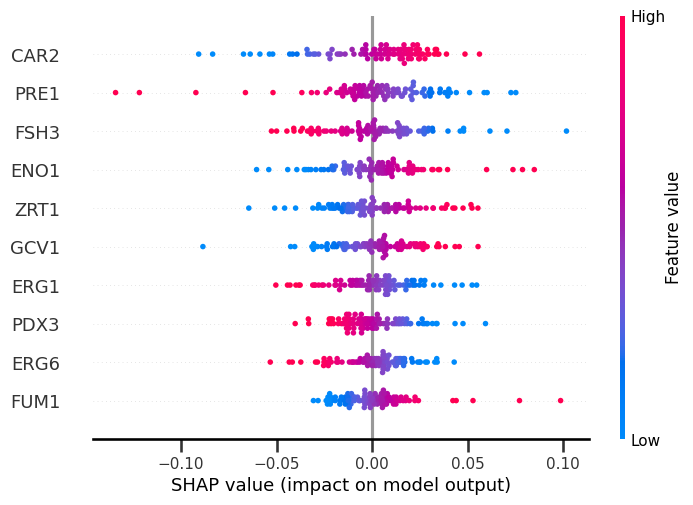

In [43]:
metabolite_id = 'pyr'
strategy = Strategy.ONE_VS_ALL
tier = Tier.TIER0
shap_explanations = get_shap_df(tier=tier, strategy=strategy)
model = load_model(tier=tier, strategy=strategy, metabolite=metabolite_id)

selected_feature_names = [x.replace('num__', '') for x in model.regressor_[:-1].get_feature_names_out()]
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
explanation = Explanation(shap_explanations[metabolite_id], feature_names=protein_info[protein_info['orf'] == selected_feature_names]['gene_prefered_name'].values.tolist())
explanation[:, :20]

vals = np.abs(explanation.values).mean(0)
order = np.argsort((-vals))
beeswarm(explanation[:, order][:, :10], max_display=10, show=False)
save_fig(path=f'./images/{MODE}/explanation/', name="pyruvate_one_vs_all_tier_0_explanation")

In [ ]:

protein_info[protein_info['orf'] == selected_feature_names]['gene_prefered_name'].values.tolist()

['EFB1',
 'SSA1',
 'ERP2',
 'CYS3',
 'FUN12',
 'CDC19',
 'ERV46',
 'GCV3',
 'ERP1',
 'RFA1',
 'ADE1',
 'ACH1',
 'NCL1',
 'LSM2',
 'PET9',
 'URA7',
 'PRE7',
 'COR1',
 'SEC17',
 'SHP1',
 'PRX1',
 'ILS1',
 'MAP2',
 'RPL32',
 'ATP1',
 'IPP1',
 'OLA1',
 'ETR1',
 'RPL4A',
 'PDX3',
 'HSP26',
 'ECM33',
 'RPG1',
 'SEC18',
 'MIS1',
 'YBR085C-A',
 'POL30',
 'NHP6B',
 'PHO88',
 'CMD1',
 'YSA1',
 'LYS2',
 'GRS1',
 'TPS1',
 'VMA2',
 'SUP45',
 'ARA1',
 'RPB5',
 'CDC28',
 'TOS1',
 'ARL1',
 'SSE2',
 'EHT1',
 'PGI1',
 'KTR3',
 'PYC2',
 'PDB1',
 'HIS7',
 'ARO4',
 'SHM1',
 'APE3',
 'ILV6',
 'NFS1',
 'LEU2',
 'RNQ1',
 'HIS4',
 'SRO9',
 'GLK1',
 'PDI1',
 'APA1',
 'PRD1',
 'KRR1',
 'CDC10',
 'YCP4',
 'CIT2',
 'RVS161',
 'PGK1',
 'RIM1',
 'THR4',
 'TUP1',
 'ABP1',
 'RPT2',
 'NOP1',
 'GPD1',
 'ARP2',
 'NAT1',
 'NPC2',
 'LHP1',
 'PSA1',
 'RPS29B',
 'IDP1',
 'RPL31A',
 'MDH3',
 'SUB2',
 'YDL086W',
 'SRP14',
 'RPN6',
 'GET3',
 'TMA17',
 'YDL124W',
 'HNT1',
 'CDC48',
 'RPP1B',
 'LYS21',
 'CCT4',
 'DHH1',
 'GLT1',
